# Gaussian Process
---

Gaussian Processes are ... THEORETICAL EXPLANATION 

One fast advantage of GP is the fact that we receive an standard deviation at every prediction, than can be easily used to perform a confindence interval around the predictions.  

[This video](https://www.youtube.com/watch?v=UpsV1y6wMQ8&t=3578s) is a fantastic quick intro to Gaussian Process to predict CO2 levels.  
[This book](http://www.gaussianprocess.org/gpml/chapters/RW.pdf) is the main guide to Gaussian Processes.  

In [1]:
import time
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

np.random.seed(2018)

In [2]:
##############################################################################
# IMPORT DATA AND WINDOWS
##############################################################################
path_to_data = './windows_ts.h5'

dataset = pd.read_hdf(path_to_data, 'dataset')
gp_trainset = pd.read_hdf(path_to_data, 'trainset')
gp_testset = pd.read_hdf(path_to_data, 'testset')

train_windows = pd.read_hdf(path_to_data, 'train_windows')
test_windows = pd.read_hdf(path_to_data, 'test_windows')
train_windows_gp_inc = pd.read_hdf(path_to_data, 'train_windows_y_inc')
test_windows_gp_inc = pd.read_hdf(path_to_data, 'test_windows_y_inc')

# Bring here the window used
w = 5

In [3]:
##############################################################################
# CREATION OF THE MODEL
##############################################################################        
from sklearn.gaussian_process import GaussianProcessRegressor as GP
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ExpSineSquared as ES
from sklearn.gaussian_process.kernels import DotProduct as DP
from sklearn.gaussian_process.kernels import Matern 
from sklearn.gaussian_process.kernels import WhiteKernel as WK

We can play with different kernels. I recommend chapter 5 of the book which I provided the link at the top to understand the use of each kernels and what they parameters mean.

In [4]:
##############################################################################
# TRAIN THE NETWORK AND PREDICT - Without previous y
############################################################################## 
# Train
trainX = train_windows.values[:,:-1]
trainY = train_windows.values[:,-1]
testX = test_windows.values[:,:-1]
testY = test_windows.values[:,-1]

l = 1.
kernels = {'cnt': C(constant_value=0.1),
           'rbf': RBF(length_scale=l),
           'ex2': ES(length_scale=l),
           'dot': DP(sigma_0=1.),
           'mat': Matern(length_scale=l , nu=1.5),
           'whi': WK(noise_level=0.01)}
           
#k = kernels['cnt'] + kernels['ex2'] + kernels['rbf'] + kernels['mat']
k = kernels['dot'] + kernels['whi']
if 'gp' in locals(): del gp
gp = GP(kernel=k, n_restarts_optimizer=9, normalize_y=True, alpha=1e-10)

# Train
t0 = time.time()
gp.fit(train_windows.values[:,:-1], train_windows.values[:,-1])
tF = time.time()

# Predict
gp_y_fit = gp.predict(trainX, return_std=False)
gp_y_pred, gp_y_std = gp.predict(testX, return_std=True)

gp_y_up = (gp_y_pred + 1.96 * gp_y_std).reshape(-1,)
gp_y_lw = (gp_y_pred - 1.96 * gp_y_std).reshape(-1,)
gp_y_pred = gp_y_pred.reshape(-1,1)


# Calculating Errors
gp_residuals = gp_y_pred - gp_testset.iloc[5:,-1].values.reshape(-1,1)
gp_rmse = np.sqrt(np.sum(np.power(gp_residuals,2)) / len(gp_residuals))
print('RMSE = %f' % gp_rmse)
print('Time to train %.2f' % (tF - t0))

RMSE = 3.555143
Time to train 0.42


In [5]:

##############################################################################
# TRAIN THE NETWORK AND PREDICT - With previous y
############################################################################## 
# Train
trainX = train_windows_gp_inc.values[:,:-1]
trainY = train_windows_gp_inc.values[:,-1]
testX = test_windows_gp_inc.values[:,:-1]
testY = test_windows_gp_inc.values[:,-1]

l = 1.
kernels = {'cnt': C(constant_value=0.01),
           'rbf': RBF(length_scale=l),
           'ex2': ES(length_scale=l),
           'dot': DP(sigma_0=0.1),
           'mat': Matern(length_scale=l , nu=1.5),
           'whi': WK(noise_level=1.)}
           
k = kernels['dot'] + kernels['whi']
if 'gp_inc' in locals(): del gp_inc
gp_inc = GP(kernel=k, n_restarts_optimizer=9, normalize_y=True, alpha=1e-10)

# Train
t0 = time.time()
gp_inc.fit(trainX,trainY)
tF = time.time()

X = np.concatenate((trainX, testX))

# Predict
gp_y_fit_inc = gp_inc.predict(trainX, return_std=False)
gp_y_pred_inc, gp_y_std_inc = gp_inc.predict(testX, return_std=True)

gp_y_up_inc = (gp_y_pred_inc + 1.96 * gp_y_std_inc).reshape(-1,)
gp_y_lw_inc = (gp_y_pred_inc - 1.96 * gp_y_std_inc).reshape(-1,)
gp_y_pred_inc = gp_y_pred_inc.reshape(-1,1)


# Calculating Errors
gp_residuals_inc = gp_y_pred_inc - gp_testset.iloc[5:,-1].values.reshape(-1,1)
gp_rmse_inc = np.sqrt(np.sum(np.power(gp_residuals_inc,2)) / len(gp_residuals_inc))
print('RMSE = %f' % gp_rmse_inc)
print('Time to train %.2f' % (tF - t0))


RMSE = 3.668108
Time to train 0.31


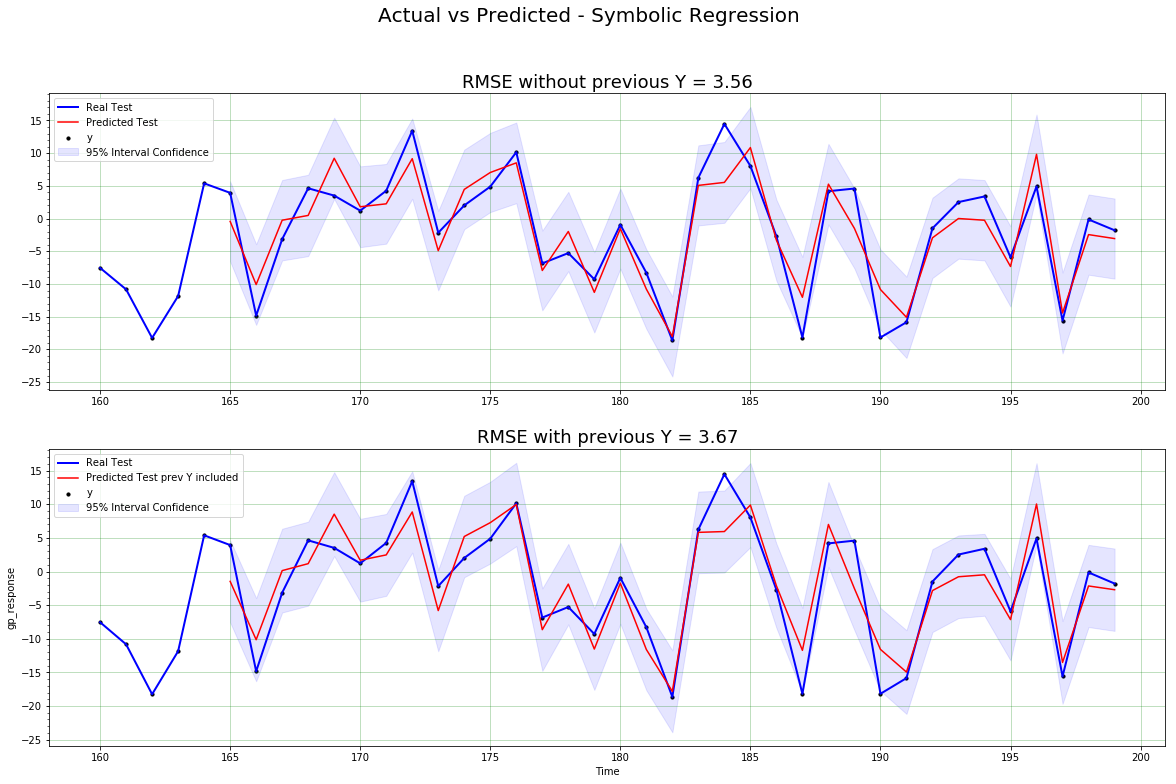

In [6]:
# Plot Predictions
def plot_sr():
    f, (ax1, ax2) = plt.subplots(2, figsize=(20,12))
    plt.suptitle('Actual vs Predicted - Symbolic Regression' , fontsize=20)
    ax1.set_title('RMSE without previous Y = %.2f' % gp_rmse, fontsize = 18)
    ax1.grid(color='green', linewidth=0.5, alpha=0.5)
    
    ax1.scatter(gp_testset.index, gp_testset.y, color='black', s=10)
    ax1.plot(gp_testset.index, gp_testset.y, linewidth=2, color='b', label='Real Test')
    ax1.plot(gp_testset.index[w:], gp_y_pred, 
             color='r', label='Predicted Test')
    ax1.fill_between(gp_testset.index[w:], 
                     gp_y_lw, 
                     gp_y_up, 
                     color='blue', alpha=0.1, label='95% Interval Confidence')
    
    ax2.set_title('RMSE with previous Y = %.2f' % gp_rmse_inc, fontsize = 18)
    ax2.grid(color='green', linewidth=0.5, alpha=0.5)
    
    ax2.scatter(gp_testset.index, gp_testset.y, color='black', s=10)
    ax2.plot(gp_testset.index, gp_testset.y, 
             linewidth=2, color='b', label='Real Test')
    ax2.plot(gp_testset.index[w:], gp_y_pred_inc, 
             color='r', label='Predicted Test prev Y included')
    ax2.fill_between(gp_testset.index[w:], 
                     gp_y_lw_inc, 
                     gp_y_up_inc, 
                     color='blue', alpha=0.1, label='95% Interval Confidence')
    
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax1.legend()
    ax2.legend()
    plt.xlabel('Time')
    plt.ylabel('gp_response')
    plt.show()

plot_sr()

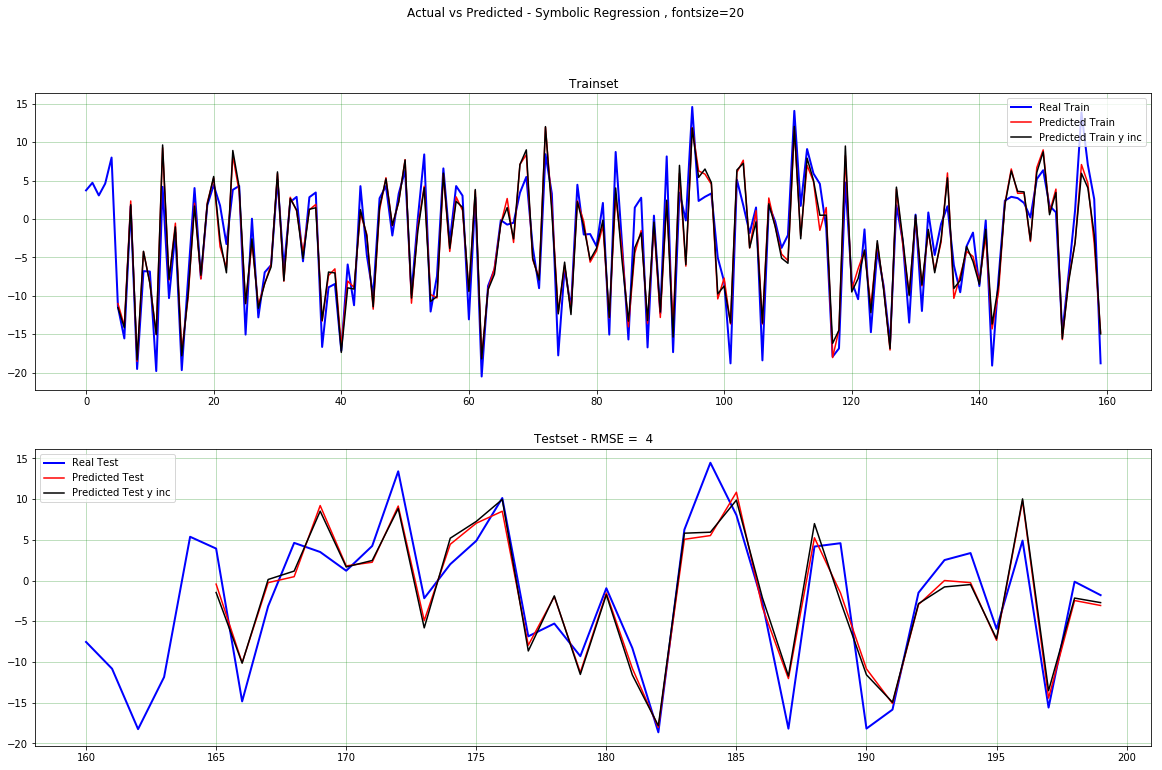

In [7]:
# Complete Plot
f, (ax1, ax2) = plt.subplots(2,1, figsize=(20,12))
plt.suptitle('Actual vs Predicted - Symbolic Regression , fontsize=20')
ax1.grid(color='green', linewidth=0.5, alpha=0.5)
ax2.grid(color='green', linewidth=0.5, alpha=0.5)

ax1.plot(gp_trainset.index, gp_trainset['y'], linewidth=2, color='b', label='Real Train')
ax1.plot(gp_trainset.index[w:], gp_y_fit, color='r', label='Predicted Train')
ax1.plot(gp_trainset.index[w:], gp_y_fit_inc, color='k', label='Predicted Train y inc')
ax1.legend()
ax1.set_title('Trainset')

ax2.plot(gp_testset.index, gp_testset.y, linewidth=2, color='b', label='Real Test')
ax2.plot(gp_testset.index[w:], gp_y_pred, color='r', label='Predicted Test')
ax2.plot(gp_testset.index[w:], gp_y_pred_inc, color='k', label='Predicted Test y inc')
ax2.set_title('Testset - RMSE = %2.f' % gp_rmse)
ax2.legend()
plt.show()    


**Conclusion**